In [1]:
%matplotlib inline

<h1>Libraries import</h1>

In [3]:
import glob
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import decomposition

from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from sklearn import metrics

import matplotlib.pyplot as plt


<h1>Data pre-processing</h1>

Data taken from https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

In [4]:
bcClass0I = []
bcClass1I = []
for f in glob.iglob("./breast_cancer_histopathology_images/0/*.png"):
    bcClass0I.append(np.asarray(Image.open(f).resize((64,64)), dtype=np.float32))

bcClass1 = []
for f in glob.iglob("./breast_cancer_histopathology_images/1/*.png"):
    bcClass1I.append(np.asarray(Image.open(f).resize((64,64)), dtype=np.float32))

bcImagesI = bcClass0I + bcClass1I

bcClass0 = np.array(bcClass0I)
bcClass1 = np.array(bcClass1I)
bcImages = np.array(bcImagesI)
bcImages = bcImages/np.linalg.norm(bcImages)

class0 = [0]*bcClass0.shape[0]
class1 = [1]*bcClass1.shape[0]
target = np.array(class0 + class1)

reshaped = np.reshape(bcImages, (bcImages.shape[0], -1))

breast_cancer = {
    "data": reshaped,
    "images": bcImages,
    "target": target
}

<b>Shape of the datas, and their data types</b>

In [5]:
print("Number of breast_cancer image = ", breast_cancer["images"].shape[0])
print("breast_cancer image data type = ", type(breast_cancer["images"][0][0][0][0]))

Number of breast_cancer image =  2022
breast_cancer image data type =  <class 'numpy.float32'>


In [6]:
print("breast_cancer image shape = ", breast_cancer["images"].shape)

breast_cancer image shape =  (2022, 64, 64, 3)


In [7]:
print("breast_cancer data shape = ", breast_cancer["data"].shape)
print("breast_cancer target shape = ", breast_cancer["target"].shape)

breast_cancer data shape =  (2022, 12288)
breast_cancer target shape =  (2022,)


<b>Data types</b>

In [8]:
print("breast_cancer image data type = ", type(breast_cancer["images"][0][0][0][0]))
print("breast_cancer data, data type = ", type(breast_cancer["data"][0][0]))
print("breast_cancer target data type = ", type(breast_cancer["target"][0]))

breast_cancer image data type =  <class 'numpy.float32'>
breast_cancer data, data type =  <class 'numpy.float32'>
breast_cancer target data type =  <class 'numpy.int64'>


<b>Split train and test data</b>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
        breast_cancer["data"],
        breast_cancer["target"],
        test_size=0.25,
        random_state=42,
        shuffle=True,
        stratify=breast_cancer["target"])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train data shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test data shape", X_test.shape)
print("Test target shape", y_test.shape)

Train data shape (1516, 12288)
Train target shape (1516,)
Test data shape (506, 12288)
Test target shape (506,)


<b>Using PCA for dimensionality reduction </b> 

In [10]:
pca = decomposition.PCA(n_components=0.9, svd_solver="auto", whiten=True)
pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [11]:
print("PCA train data shape = ", X_train_pca.shape)
print("PCA test data shape", X_test_pca.shape)

PCA train data shape =  (1516, 353)
PCA test data shape (506, 353)


<h1>Model : SVM</h1>

<h3>Model selection</h3>

In [11]:
param_grid = {
    "C": loguniform(1e3, 1e4),
    "gamma": loguniform(1e-4, 1e-1),
    "kernel": ["rbf"],
    "class_weight":["balanced"]
}
clf = RandomizedSearchCV(
    svm.SVC(),
    param_grid,
    n_iter=10
)
clf.fit(X_train_pca, y_train)

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe2f0a46fb0>,
                                        'class_weight': ['balanced'],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe2f0a47d00>,
                                        'kernel': ['rbf']})

In [12]:
print("Best estimator found by randomized search:")
print(clf.best_estimator_)

Best estimator found by randomized search:
SVC(C=4184.88854880601, class_weight='balanced', gamma=0.0051665798490559385)


<h3>Train </h3>
<b>Using K-SVM with rbf kernel and the calculated hyperparameters. </b>

In [13]:
clf1 = svm.SVC(C=4184.88854880601, class_weight='balanced', gamma=0.0051665798490559385, kernel= "rbf")
clf1.fit(X_train_pca, y_train)

SVC(C=4184.88854880601, class_weight='balanced', gamma=0.0051665798490559385)

<h3>Model Evaluation</h3>

<b>Score for the Train data</b>

In [14]:
trainScore = clf1.score(X_train_pca, y_train)
print("Train score = ", trainScore)

Train score =  1.0


<b>Score for the Test data</b>

In [15]:
testScore = clf1.score(X_test_pca, y_test)
print("Test score = ", testScore)

Test score =  0.8102766798418972


<b>Classification Report on prediction </b>

In [16]:
y_pred = clf1.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.70      0.75       203
           1       0.81      0.88      0.85       303

    accuracy                           0.81       506
   macro avg       0.81      0.79      0.80       506
weighted avg       0.81      0.81      0.81       506



<b>Confusion Matrix</b>

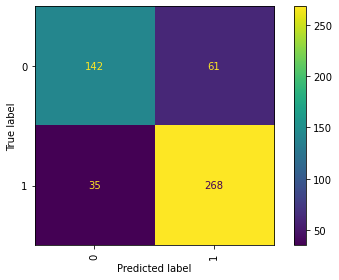

In [17]:
metrics.ConfusionMatrixDisplay.from_estimator(
    clf1, X_test_pca, y_test, display_labels=[0,1], xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

<h1>Model : KNN</h1>

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

<h3>Model Selection</h3>

In [82]:
k_values = np.arange(1, 20)
accuracy_scores = []
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, X_train_pca, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(scores.mean())

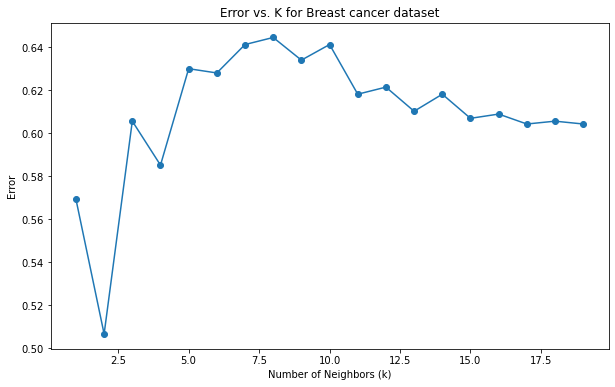

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('Error vs. K for Breast cancer dataset')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.show()

<h3>Train</h3>

In [84]:
knn_classifier = KNeighborsClassifier(n_neighbors=2)  # You can adjust the value of 'n_neighbors'
knn_classifier.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=2)

<h3>Model Evaluation</h3>

In [85]:
y_pred = knn_classifier.predict(X_test_pca)  # For classification

In [86]:
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.45849802371541504
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.74      0.52       203
           1       0.61      0.27      0.37       303

    accuracy                           0.46       506
   macro avg       0.51      0.51      0.45       506
weighted avg       0.53      0.46      0.43       506



<h3>Confusion matrix</h3>

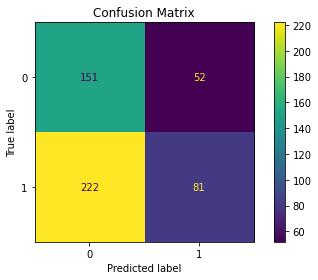

In [87]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(values_format='d')

plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

<h1>Model : Logistic Regression</h1>

In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


<h3>Train</h3>

In [89]:
logreg = LogisticRegression()
logreg.fit(X_train_pca, y_train)

LogisticRegression()

<h3>Model Evaluation</h3>

In [90]:
y_pred = logreg.predict(X_test_pca)

In [91]:
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8181818181818182
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       203
           1       0.82      0.89      0.85       303

    accuracy                           0.82       506
   macro avg       0.82      0.80      0.81       506
weighted avg       0.82      0.82      0.82       506



<h3>Confusion Matrix</h3>

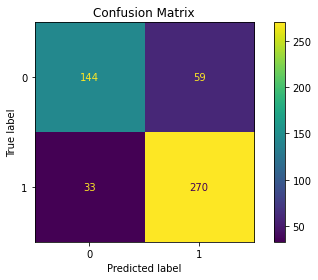

In [92]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(values_format='d')

plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
